# Introduction

In the last notebook, we already talked about how to visualize the return of a long term investment plan. 

We made an assumption that the annual return rate is about 5%. How can we ensure that we can invest our savings properly so that we can have a 5% annual return?

In this notebook, we are going to use the historical data of SP500 to do some backtesting.

We will calculate the overall rate of return and the internal rate of return for two dollor cost averaging methods.

In [1]:
# Import libraries
import datetime
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

plt.style.use('bmh')
warnings.filterwarnings("ignore")

# A peak into the history

The first step here is to download data. I used a method introducted in a [datacamp tutorial](https://www.datacamp.com/community/tutorials/finance-python-trading).

The [total return index](https://www.investopedia.com/terms/t/total_return_index.asp#:~:text=The%20total%20return%20index%20is,representation%20of%20the%20index's%20performance) of SP500 between 1988 and 2020 is used here.

In [2]:
# Get historical data
startdate = datetime.datetime(1988, 1, 1)
enddate = datetime.datetime(2021, 1, 1)

# SP 500 Total return index
SP = pdr.get_data_yahoo('^SP500TR', start=startdate, end=enddate)

# If you want to use the price index of SP500, you can use the ticker of '^GSPC'
# SP = pdr.get_data_yahoo('^GSPC', start=startdate, end=enddate)

In [3]:
SP

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1988-01-04,256.019989,256.019989,256.019989,256.019989,0,256.019989
1988-01-05,258.769989,258.769989,258.769989,258.769989,0,258.769989
1988-01-06,259.029999,259.029999,259.029999,259.029999,0,259.029999
1988-01-07,261.209991,261.209991,261.209991,261.209991,0,261.209991
1988-01-08,243.550003,243.550003,243.550003,243.550003,0,243.550003
...,...,...,...,...,...,...
2020-08-17,6954.669922,6937.540039,6940.890137,6943.220215,0,6943.220215
2020-08-18,6971.020020,6920.080078,6954.689941,6960.299805,0,6960.299805
2020-08-19,6981.410156,6920.370117,6967.069824,6930.799805,0,6930.799805


In [4]:
# Generate group by keys
SP['date'] = SP.index
SP['year'] = SP['date'].apply(lambda d: f'{d.year}')

# Group by year, take the adjusted close price of the first business day in each year
df = SP[['year', 'Adj Close']].sort_index().groupby('year').first()

# Generate annual return
df['return'] = df['Adj Close'].pct_change()

# Show annual return by the beginning of next year
df['return_next_y'] = df['return'].shift(-1)

df = df.drop(columns='return')
df = df.reset_index()

df

,year,Adj Close,return_next_y
0,1988,256.019989,0.115733
1,1989,285.649994,0.351864
2,1990,386.160004,-0.058836
3,1991,363.440002,0.320273
4,1992,479.839996,0.075358
5,1993,516.000000,0.099031
6,1994,567.099976,0.014848
7,1995,575.520020,0.386954
8,1996,798.219971,0.214014
9,1997,969.049988,0.346721


In [5]:
# Describe the annual return
df['return_next_y'].describe()

count    32.000000
mean      0.120554
std       0.169035
min      -0.340563
25%       0.022687
50%       0.141676
75%       0.242569
max       0.386954
Name: return_next_y, dtype: float64

When checking the annual return rate, the minimum value is  -34.1% and maximum value is 38.7%.
So we should not be panic if we see a drop of 30-40% in the total value in a certain year. Try to buy more in the dip, and the bull market will follow in 1-3 years.

# Define functions

In [6]:
def calc_dollar_cost_averaging_return(df_dc: pd.DataFrame, value_per_period: float = 1.0, 
                                      increase_investment_per_period: float = 0.0,
                                      display_returns: bool = True) -> pd.DataFrame:
    """
    This function calculates the overall rate of return and the internal rate of return of dollar cost averaging method. 
    :param df_dc: Original dataframe that contains the price at the beginning of each period
    :param value_per_period: Investment value per period
    :param increase_investment_per_period: Increase the investment by x each period
    :param display_returns: Whether to display return results or not
    :return: A dataframe that contains all the relevant info
    """
    # amount to invest each period
    df_dc.loc[0, 'should_invest'] = value_per_period   
    # total amount of investment after the investment this period
    df_dc.loc[0, 'total_invest'] = value_per_period   
    # the total value by the beginning of next period
    df_dc.loc[0, 'total_value_next'] = value_per_period*(1 + df_dc.loc[0, 'return_next_y'])
    df_dc.loc[0, 'overall_return_next'] = df_dc.loc[0, 'total_value_next'] / df_dc.loc[0, 'total_invest'] - 1

    for i in range(1,len(df_dc.index)):
        df_dc.loc[i, 'should_invest'] = value_per_period * (1 + increase_investment_per_period)**i
        df_dc.loc[i, 'total_invest'] = df_dc.loc[i-1, 'total_invest'] + df_dc.loc[i, 'should_invest']
        df_dc.loc[i, 'total_value_next'] = ((df_dc.loc[i-1, 'total_value_next'] + 
                                            df_dc.loc[i, 'should_invest']) *
                                            (1 + df_dc.loc[i, 'return_next_y']) 
                                           )
        df_dc.loc[i, 'overall_return_next'] = df_dc.loc[i, 'total_value_next'] / df_dc.loc[i, 'total_invest'] - 1
        
    if display_returns:
        
        # Calculate overall return
        overall_return = round(df_dc.loc[len(df_dc.index) - 2, 'overall_return_next']*100, 2)
        print(f"The overall return rate is {overall_return}%")

        # Calculate IRR
        cf = (-df_dc['should_invest']).tolist()
        cf[-1] = df_dc.loc[len(df_dc.index) - 2, 'total_value_next']
        print("The cash flow (the negative sign stands for investment):")
        display(cf)
        irr = round(100*np.irr(cf), 2)
        print(f"The internal return rate (IRR) is {irr}% per period")
        
        # Calculate CAGR
        cagr = round(100*((df_dc.loc[len(df_dc.index) - 2, 'total_value_next']/
                           df_dc.loc[len(df_dc.index) - 2, 'total_invest'])**(1/(len(df_dc.index) - 1)) - 1), 2)
        
        print(f"The compound annual growth rate (CAGR) is {cagr}% per period")
        
    return df_dc


def plot_changes(df: pd.DataFrame,
                 y1: str = 'total_invest', y2: str = 'total_value_next',
                 xlabel: str = 'period', ylabel: str = 'value',
                 title: str = 'Visualize total investment and value each year',
                 target: int = None) -> None:
    """
    This function visualizes the total investment and the total value of the investment plan across time
    :param df: A dataframe contains total investment and total value
    :param y1: Column name
    :param y2: Column name
    :param xlabel: X label
    :param ylabel: Y label
    :param title: Title of the graph
    :return: A plot
    """
    plt.figure(figsize=(15, 5))
    plt.plot(df[y1], label=y1)
    plt.plot(df[y2], label=y2)
    if target:
        plt.axhline(y=target, c='black', label='target value')
    plt.xlim([0, len(df[y1])-1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plan 1: Yearly [dollar cost averaging](https://en.wikipedia.org/wiki/Dollar_cost_averaging) buying method

Imagine we were able to invest 1200 dollar per year into a SP500 index based ETF starting from 1988.

What's the overall return after 32 years?

What's the average annual return?

In [7]:
df1 = calc_dollar_cost_averaging_return(df, value_per_period=1200)

The overall return rate is 580.19%
The cash flow (the negative sign stands for investment):


[-1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 -1200.0,
 261192.11446741945]

The internal return rate (IRR) is 9.92% per period
The compound annual growth rate (CAGR) is 6.17% per period


In [8]:
df1

,year,Adj Close,return_next_y,should_invest,total_invest,total_value_next,overall_return_next
0,1988,256.019989,0.115733,1200.0,1200.0,1338.879804,0.115733
1,1989,285.649994,0.351864,1200.0,2400.0,3432.220743,0.430092
2,1990,386.160004,-0.058836,1200.0,3600.0,4359.680708,0.211022
3,1991,363.440002,0.320273,1200.0,4800.0,7340.295930,0.529228
4,1992,479.839996,0.075358,1200.0,6000.0,9183.879488,0.530647
5,1993,516.000000,0.099031,1200.0,7200.0,11412.205047,0.585028
6,1994,567.099976,0.014848,1200.0,8400.0,12799.465363,0.523746
7,1995,575.520020,0.386954,1200.0,9600.0,19416.618801,1.022564
8,1996,798.219971,0.214014,1200.0,10800.0,25028.857872,1.317487
9,1997,969.049988,0.346721,1200.0,12000.0,35322.955610,1.943580


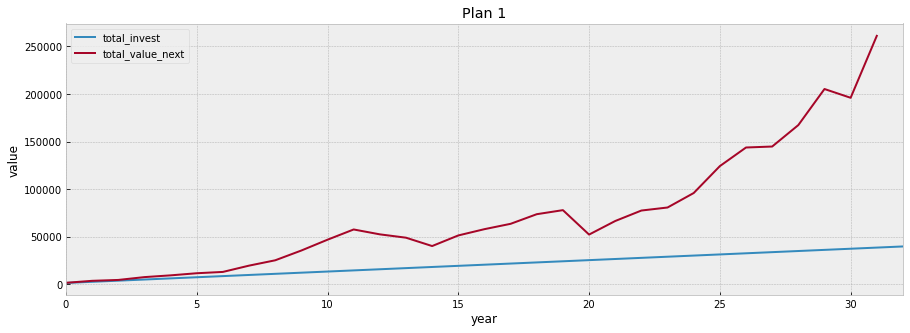

In [9]:
plot_changes(df1, title='Plan 1', xlabel='year')

# Plan 2: Increase the investment each year by 2%

In [10]:
# Assuming initial_investment is 1200, and then increase investment each year by 2%
df2 = calc_dollar_cost_averaging_return(df, value_per_period=1200, increase_investment_per_period=0.02)

The overall return rate is 486.51%
The cash flow (the negative sign stands for investment):


[-1200.0,
 -1224.0,
 -1248.48,
 -1273.4496000000001,
 -1298.918592,
 -1324.8969638400001,
 -1351.3949031168002,
 -1378.422801179136,
 -1405.991257202719,
 -1434.1110823467732,
 -1462.7933039937088,
 -1492.049170073583,
 -1521.8901534750546,
 -1552.327956544556,
 -1583.374515675447,
 -1615.042005988956,
 -1647.3428461087349,
 -1680.2897030309098,
 -1713.8954970915281,
 -1748.1734070333584,
 -1783.1368751740258,
 -1818.7996126775063,
 -1855.1756049310566,
 -1892.2791170296778,
 -1930.1246993702714,
 -1968.7271933576767,
 -2008.1017372248302,
 -2048.263771969327,
 -2089.2290474087135,
 -2131.0136283568877,
 -2173.633900924026,
 -2217.106578942506,
 311273.63335198513]

The internal return rate (IRR) is 9.91% per period
The compound annual growth rate (CAGR) is 5.68% per period


In [11]:
df2

,year,Adj Close,return_next_y,should_invest,total_invest,total_value_next,overall_return_next
0,1988,256.019989,0.115733,1200.000000,1200.000000,1338.879804,0.115733
1,1989,285.649994,0.351864,1224.000000,2424.000000,3464.665484,0.429317
2,1990,386.160004,-0.058836,1248.480000,3672.480000,4435.844184,0.207861
3,1991,363.440002,0.320273,1273.449600,4945.929600,7537.826024,0.524046
4,1992,479.839996,0.075358,1298.918592,6244.848192,9502.668090,0.521681
5,1993,516.000000,0.099031,1324.896964,7569.745156,11899.829221,0.572025
6,1994,567.099976,0.014848,1351.394903,8921.140059,13447.972306,0.507428
7,1995,575.520020,0.386954,1378.422801,10299.562860,20563.532573,0.996544
8,1996,798.219971,0.214014,1405.991257,11705.554117,26671.303126,1.278517
9,1997,969.049988,0.346721,1434.111082,13139.665200,37850.153571,1.880603


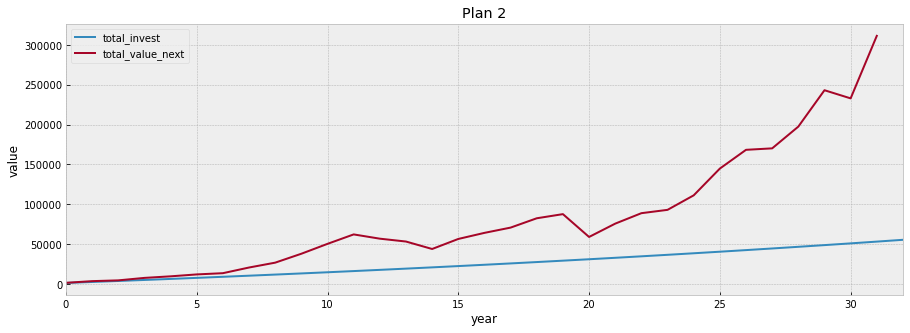

In [12]:
plot_changes(df2, title='Plan 2', xlabel='year')

# Conclusion

The compound annual growth rate of Plan 2 is lower than that of Plan 1. This is because Plan 2 invested more money at the later stage of the investment. But, in both plans, the compound annual growth rates are more than 5%.

The internal return rate of both plans are quite similiar to each other (almost 10%). 

It seems that SP500 is a good enough index that can bring us long term return. However, the historical data cannot predict the future. Please do your own research before investing.

In the next notebook, we will further discuss which strategy can further increase IRR.
